### Importing necessary Library for the Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore")

### Importing the dataset:

In [2]:
sales = pd.read_excel('Wholesale customers data.xlsx')
sales.head(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
sales.shape

(440, 8)

In [5]:
sales.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

### About the dataset

The dataset illustrates the clients of a wholesale distributor. It has the annual spending in monetary units on different kind of products like Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicassen. The dataset is small with 440 rows and 8 columns. All the columns are of integer type. 

**Attribute Information :**

1. **Fresh**: annual spending on fresh products (integer, continuous)
2. **Milk**: annual spending on Milk products (integer, continuous)
3. **Grocery**: annual spending on Grocery products (integer, continuous)
4. **Frozen**: annual spending on Frozen products (integer, continuous)
5. **Detergent Paper**: annual spending on Detergent products (integer, continuous)
6. **Delicassen**: annual spending on Delicassen products (integer, continuous)
7. **Channel**: who are the customers (integer, nominal). **Horeca (Hotel/Restaurant/Cafe) and Retail**
8. **Region**: where does these customer live (integer,nominal) **Lisnon, Oporto and Other**



`OBJECTIVE
The objective of the project is to describe the variation in the different types of customer that the wholesale distributor interacts with, with the help of Machine Learning.`

### Data Cleaning:

In [6]:
sales.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [7]:
sales.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [8]:
sales.duplicated().sum()

0

Since, there is no null values, duplicate values and NaN values in our dataset. We don't have to do anything to clean the dataset. A clean dataset was provide to us.

### Exploratory Data Analysis (EDA):

Here, we will try to better analysis our dataset like by doing the descriptive analytics, checking of outliers with the help of box-plot, we will be seeing if the distribution is normal or not with the help of histogram/KDE plot and finally we will be corealtion between the features.

In [9]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0


The min and max values of the products has high variation. So, the reason might be that, we have a lot of outliers. 

### Checking for outliers with the help of box-plot

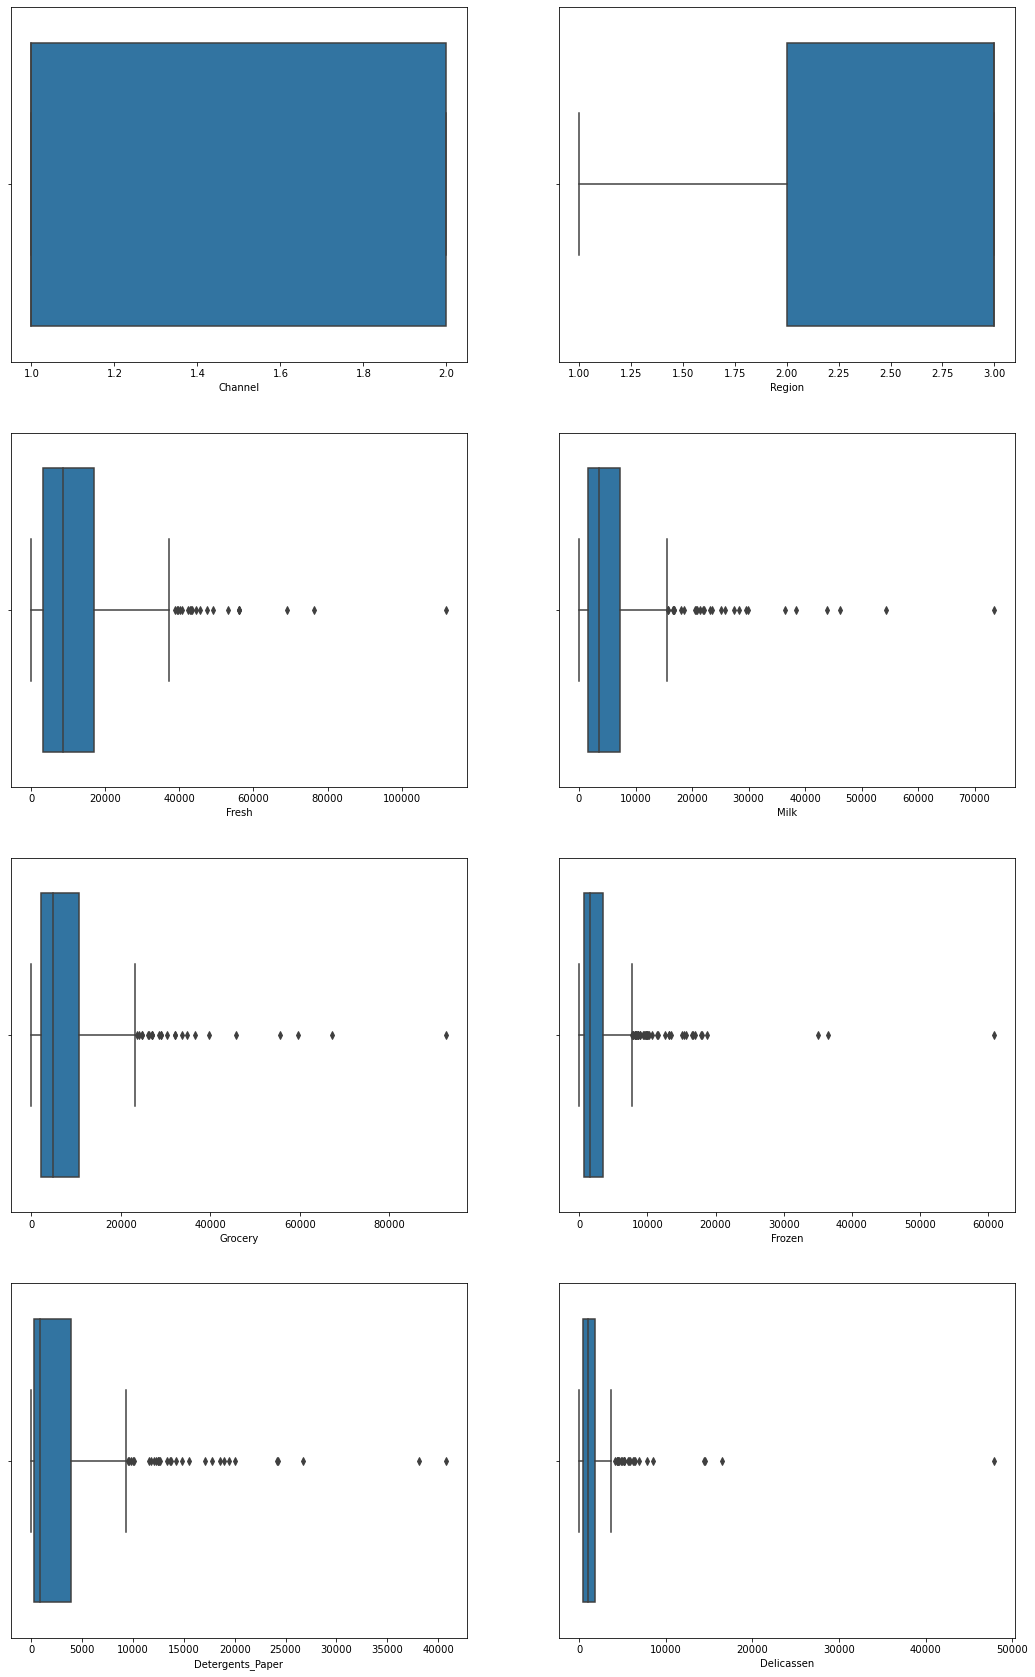

In [10]:
count = 0
sales_col = sales.columns

fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(18,30))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(data=sales,x = sales_col[count],ax=ax[i][j])
        count +=1

From the boxplot, we can see that, we have a lot of outliers in almost all the columns except channel and region. Since, we have very small number of data in our dataset. We cannot loose any of the data so we will be using the **clip function in pandas** which will set the maximum values according to the quartile we give it. But, firstly, we need to find that approprate quartile.

In [11]:
def detect_outlier(feature):
    outliers = []
    data = sales[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 2:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --2sd: {:.1f} / {} values exceed that'.format(mean + 2*(std), len(outliers)))

In [12]:
for cols in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    detect_outlier(cols)


Outlier caps for Fresh:
  --95p: 36818.5 / 22 values exceed that
  --2sd: 37266.2 / 20 values exceed that

Outlier caps for Milk:
  --95p: 16843.4 / 22 values exceed that
  --2sd: 20540.2 / 19 values exceed that

Outlier caps for Grocery:
  --95p: 24033.5 / 22 values exceed that
  --2sd: 26936.0 / 15 values exceed that

Outlier caps for Frozen:
  --95p: 9930.7 / 22 values exceed that
  --2sd: 12770.2 / 15 values exceed that

Outlier caps for Detergents_Paper:
  --95p: 12043.2 / 22 values exceed that
  --2sd: 12406.4 / 21 values exceed that

Outlier caps for Delicassen:
  --95p: 4485.4 / 22 values exceed that
  --2sd: 7158.7 / 6 values exceed that


Since we have about 22 datapoints which are above 95 percentile of our dataset and are close to 2 standard deviation. This indicates that, 95% of our data is within 2 standard deviation of the mean.

We can take that percentile and cut off and make that value the max value.

In [13]:
for cols in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    sales[cols].clip(upper=sales[cols].quantile(.95), inplace=True)

In [14]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.00
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.00
Fresh,440.0,11319.543182,10114.463397,3.0,3127.75,8504.0,16933.75,36818.50
Milk,440.0,5116.495000,4556.329065,55.0,1533.00,3627.0,7190.25,16843.40
Grocery,440.0,7269.315909,6678.434278,3.0,2153.00,4755.5,10655.75,24033.50
Frozen,440.0,2659.953409,2772.620884,25.0,742.25,1526.0,3554.25,9930.75
Detergents_Paper,440.0,2544.314545,3338.860478,3.0,256.75,816.5,3922.00,12043.20
Delicassen,440.0,1298.654091,1166.235766,3.0,408.25,965.5,1820.25,4485.40


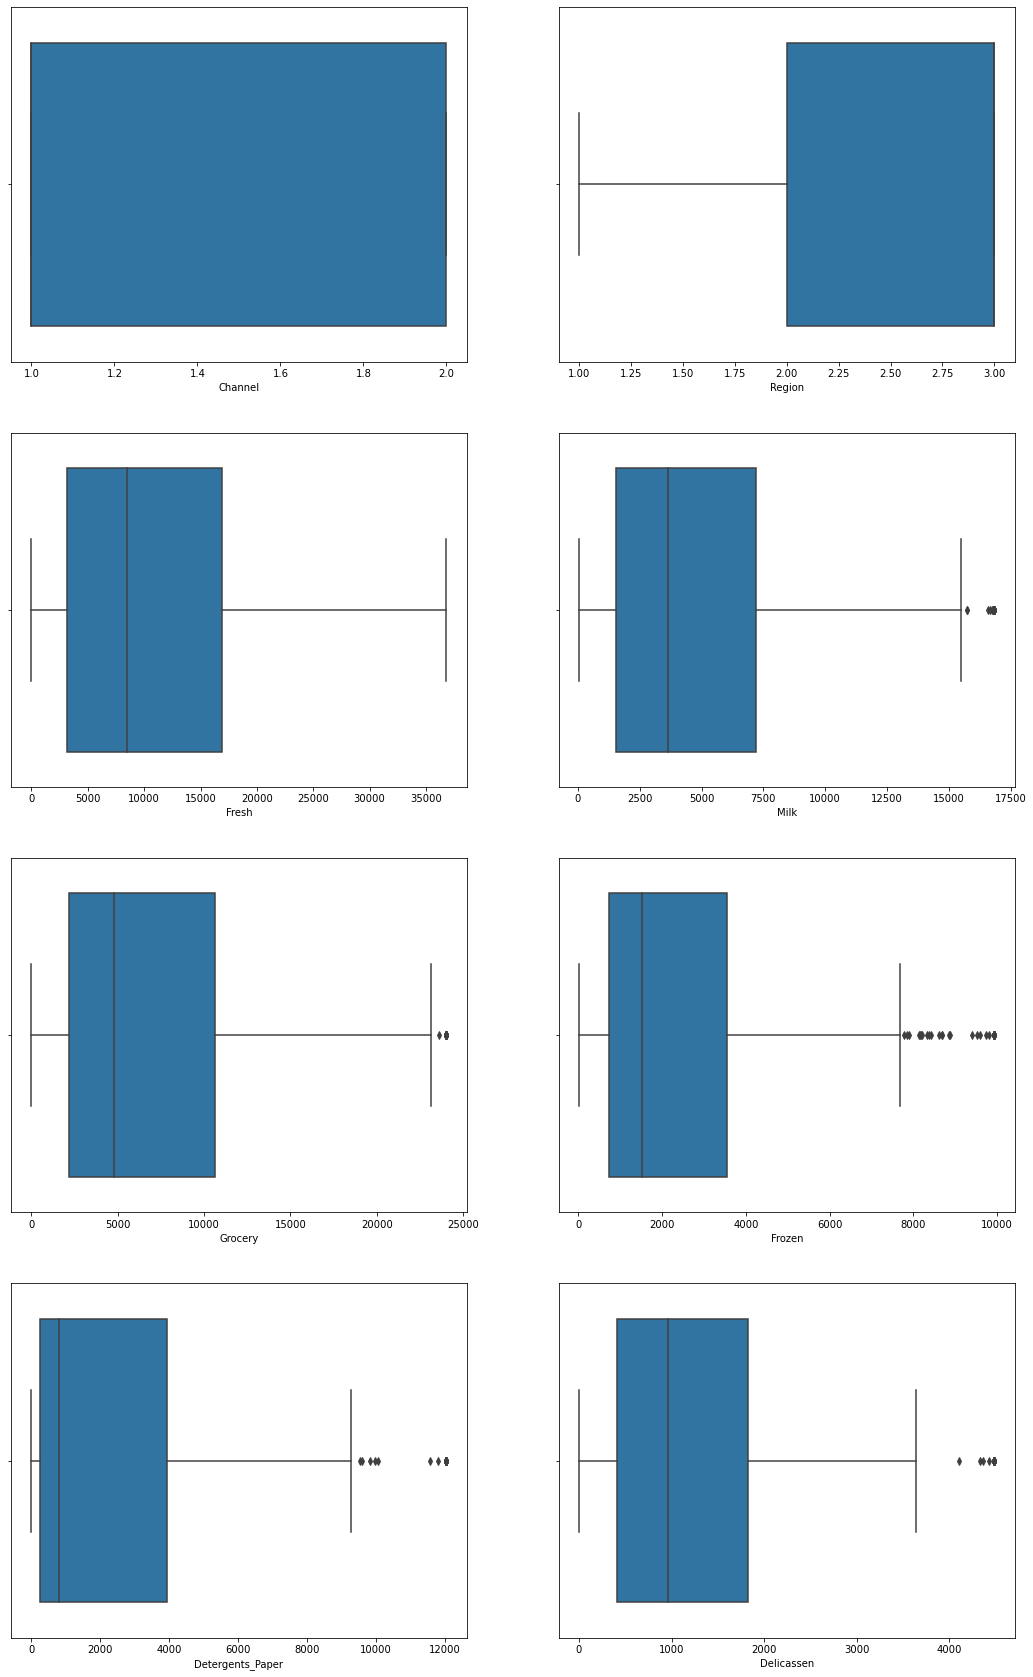

In [15]:
count = 0
sales_col = sales.columns

fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(18,30))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.boxplot(data=sales,x = sales_col[count],ax=ax[i][j])
        count +=1

In [16]:
sales.shape

(440, 8)

So, after the outliers removal, we can see, our boxplot is giving us a good plot of our data. There has been a drastical change in our dataset in terms of outliers. We can see that, some of the data points in our dataset are still outliers but we assume that, in some days the business cost got up and the wholesale dealer spend more than usual for that product. So, we will not be doing anything to those outliers. 

Also, we have not removed any of our datapoint which will help us to accurately find our result.

### Correlation between different features

<AxesSubplot:>

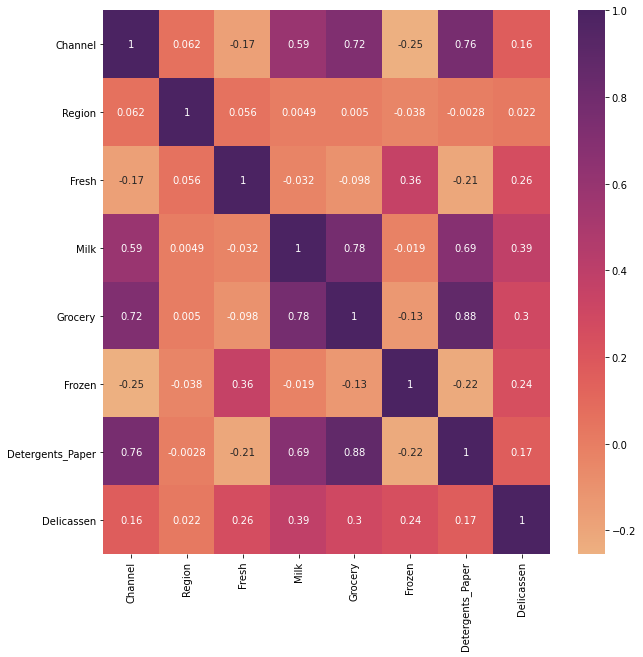

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(sales.corr(), annot=True, cmap="flare")

Here, channel being the target variable, we will be looking into other features in realtionship with it. We can see that, Fresh and Frozen are negatively coorelated with the channel while other variables like Milk, Grocery, Detergent Paper and Delicassen are positively coorealted. We can see that, the region variable is not too corealted with channel like other which means region is the least important variable in our dataset.

Also, the grocery and Detergents Paper are highly corealted with each other i.e 88%, followed by grocery and milk with 78%. This might mean while spending in Grocery the whole sale distributer also spend similar amount on Milk and Detergents Paper.

### Checking the distribution of data using histogram:

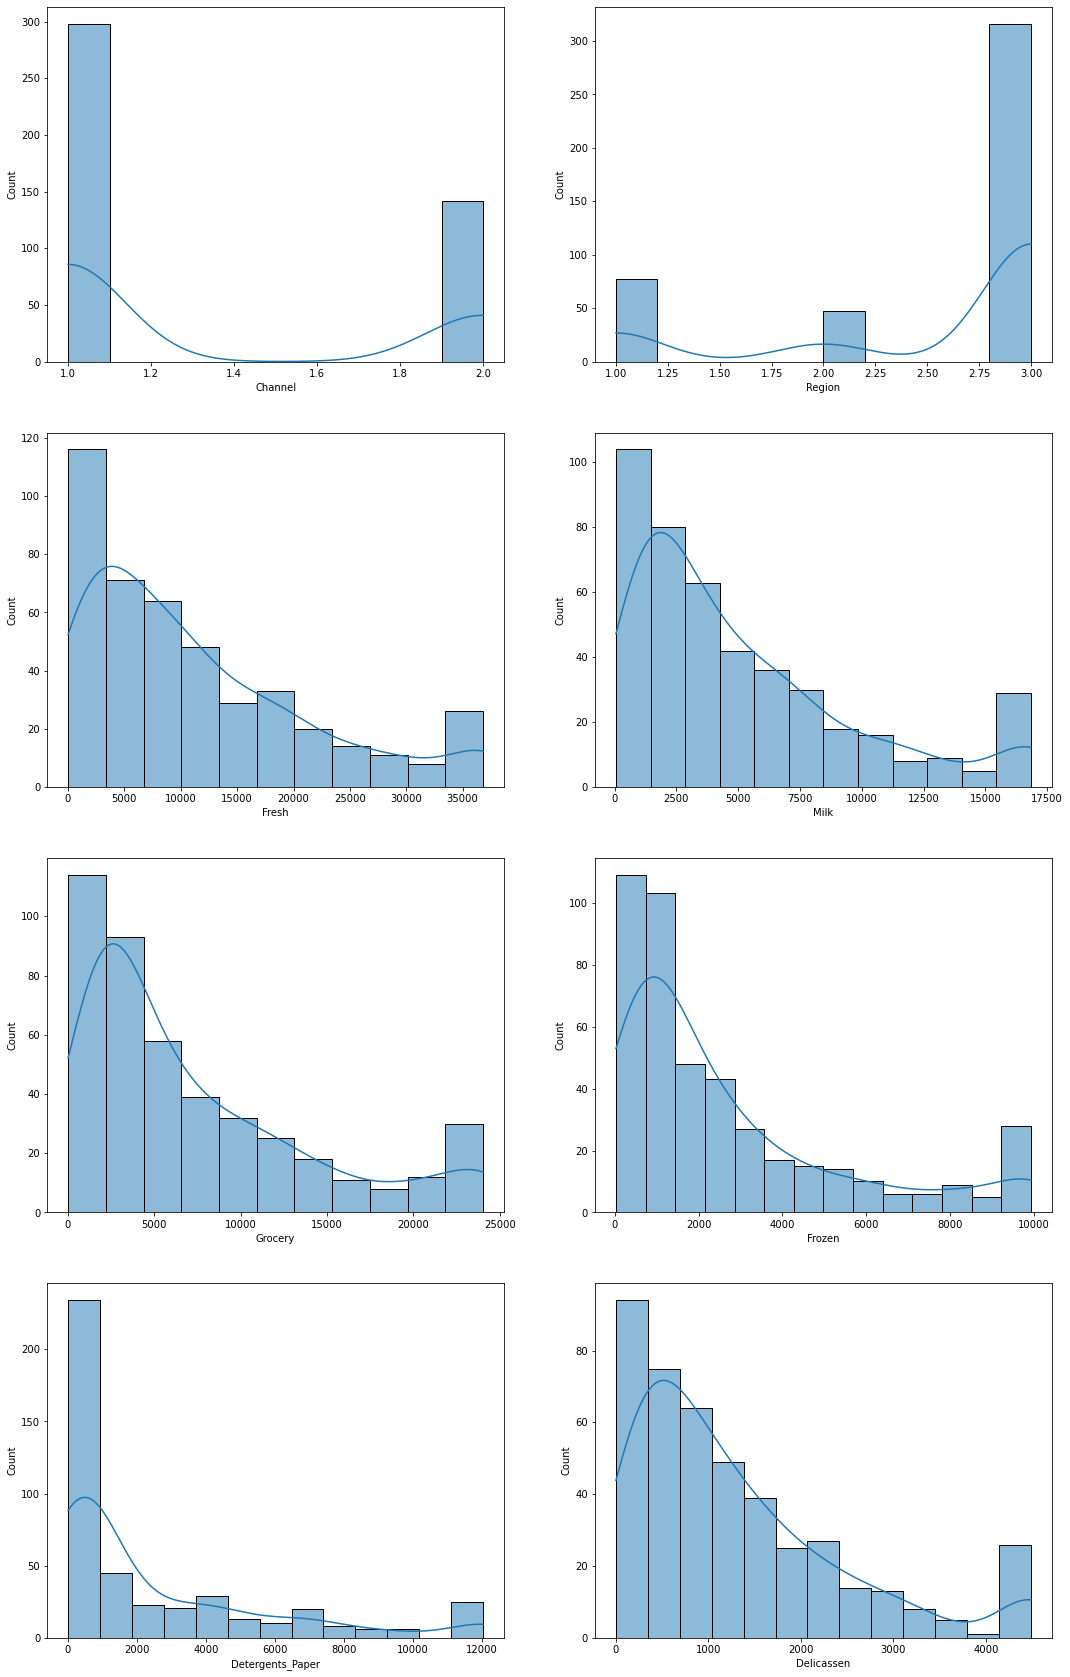

In [18]:
count = 0
sales_col = sales.columns

fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(18,30))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        sns.histplot(data=sales,x = sales_col[count], kde=True, ax=ax[i][j])
        count +=1

In [19]:
before = sales.agg(['skew']).transpose()
before

,skew
Channel,0.760951
Region,-1.283627
Fresh,1.077862
Milk,1.218350
Grocery,1.214326
Frozen,1.420090
Detergents_Paper,1.582278
Delicassen,1.301279


From the histogram, we can see that, most of our product category are heavely left skeweed. At the end of every histogram, we can see that, the highest number has a little bump because we cut off and replaced the highest value of all the outliers to that value. Also, we can see that, the channel and region has only 2 and 3 unique values. 

The skewnees value is also high for all of our products. So, to better normalize the data and bring them to acceptable range we are going to perform feature scaling.

### Feature Scaling:

For the feature scaling, we will be testing two scaling methods form sklearn library.

1. StandardScaler
2. MinMaxScaler

We will be using the method which gives us best normalization of our data. But, before scaling all of our features we need to seperate the features (X) and target (y) variables. So, here, the channel is our target variable and all other columns are the feature variables.

In [20]:
X = sales.drop(['Channel'],axis=1)
X

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3,12669.0,9656.0,7561.0,214.00,2674.0,1338.0
1,3,7057.0,9810.0,9568.0,1762.00,3293.0,1776.0
2,3,6353.0,8808.0,7684.0,2405.00,3516.0,4485.4
3,3,13265.0,1196.0,4221.0,6404.00,507.0,1788.0
4,3,22615.0,5410.0,7198.0,3915.00,1777.0,4485.4
...,...,...,...,...,...,...,...
435,3,29703.0,12051.0,16027.0,9930.75,182.0,2204.0
436,3,36818.5,1431.0,764.0,4510.00,93.0,2346.0
437,3,14531.0,15488.0,24033.5,437.00,12043.2,1867.0
438,3,10290.0,1981.0,2232.0,1038.00,168.0,2125.0


In [21]:
y = sales['Channel']
y

0      2
1      2
2      2
3      1
4      2
      ..
435    1
436    1
437    2
438    1
439    1
Name: Channel, Length: 440, dtype: int64

#### StandardScaler:

The StandardScaler standardize the features by making the mean value 0 and the standard deviation of 1. It follows standard normal distribution.  In case of multivariate data, this is done feature wise which makes it independent for each columns.

In [22]:
standard_scaler = StandardScaler().fit_transform(X)
standard_scaler

array([[ 0.59066829,  0.1335704 ,  0.99744164, ..., -0.88318517,
         0.03888545,  0.03377593],
       [ 0.59066829, -0.4219102 ,  1.03127925, ..., -0.32423313,
         0.22448907,  0.40977072],
       [ 0.59066829, -0.49159272,  0.81111505, ..., -0.09205861,
         0.29135435,  2.73561615],
       ...,
       [ 0.59066829,  0.31787276,  2.27887643, ..., -0.8026643 ,
         2.84818672,  0.48788836],
       [ 0.59066829, -0.10190507, -0.68894588, ..., -0.58565514,
        -0.71252439,  0.70936475],
       [ 0.59066829, -0.84455848, -0.75112799, ..., -0.93698611,
        -0.6198725 , -1.07017226]])

In [23]:
standard_df = pd.DataFrame(standard_scaler,columns = X.columns)

<AxesSubplot:ylabel='Density'>

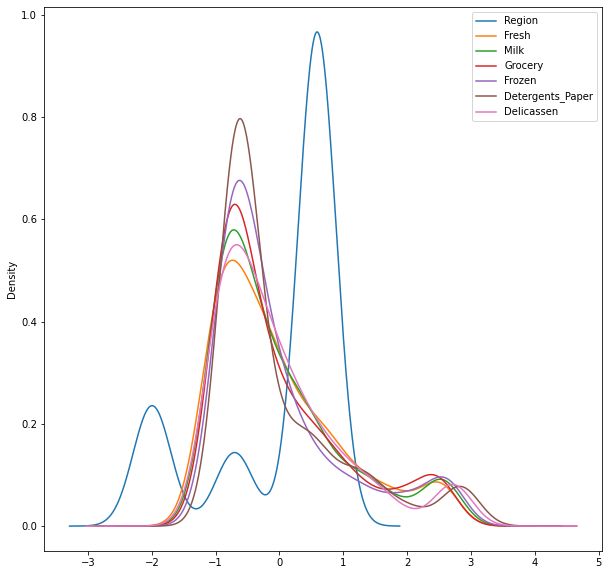

In [24]:
standard_df.plot(kind='kde',figsize = (10,10))

<AxesSubplot:ylabel='Frequency'>

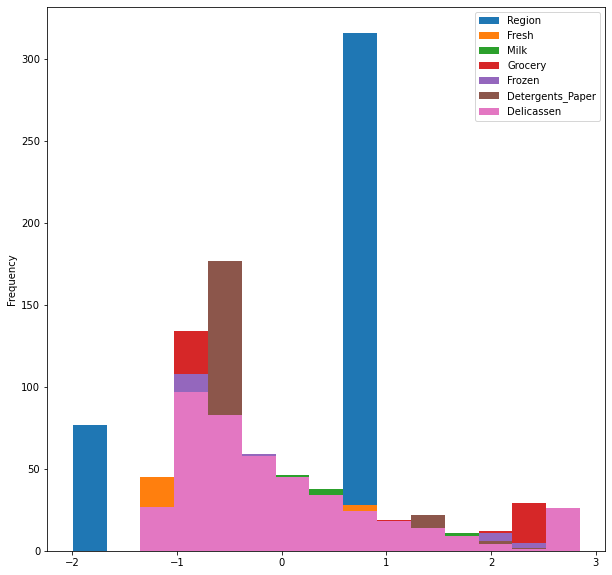

In [25]:
standard_df.plot(kind='hist', bins=15, figsize = (10,10))

The kde plot shows us after standard scaling, the distribution was somewhat normal with a mean of 0 and standard deviation of 1. The region feature being a nominal/categorical variable shows some abnormal behaviour which is fine for a categorical variable. 

The histogram shows the same result region showing a abnormal distribution and other with somewhat left skeweed data but which can be considered as normal. 

### MinMaxScaler:

MinMaxScaler is another popular library in sklearn for feature scaling. It transform the features by scaling each feature in a given range. In MinMaxScaler, we can give a certain range in which we want our data to be. By default, the data will be scaled in range of 0 to 1. This method is good when we want only positive values or the model/statical test we are trying to run only accept positive values like Chi-Square test. 

However, it only does the linear transformation of data rather than acutally normalizing the data based on standard deviation and mean which StandardScaler does. In addition to that, they are highly susceptible to the outliers and the outliers can highly distort our result. So, for using the MinMaxScaler method, we need to remove all our outliers. 

In [26]:
minmax = MinMaxScaler().fit_transform(X)
minmax

array([[1.        , 0.34403987, 0.57188297, ..., 0.01907983, 0.22184017,
        0.29783152],
       [1.        , 0.19160408, 0.58105597, ..., 0.1753527 , 0.27325127,
        0.39554703],
       [1.        , 0.1724817 , 0.5213719 , ..., 0.24026449, 0.29177256,
        1.        ],
       ...,
       [1.        , 0.3946164 , 0.91926568, ..., 0.041592  , 1.        ,
        0.41584865],
       [1.        , 0.27942035, 0.11472207, ..., 0.10226384, 0.01370409,
        0.4734071 ],
       [1.        , 0.07562032, 0.09786519, ..., 0.00403806, 0.03936812,
        0.01093164]])

In [27]:
minmax_df = pd.DataFrame(minmax,columns = X.columns)
minmax_df

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,0.344040,0.571883,0.314517,0.019080,0.221840,0.297832
1,1.0,0.191604,0.581056,0.398036,0.175353,0.273251,0.395547
2,1.0,0.172482,0.521372,0.319635,0.240264,0.291773,1.000000
3,1.0,0.360229,0.067964,0.175527,0.643969,0.041860,0.398224
4,1.0,0.614198,0.318970,0.299411,0.392701,0.147340,1.000000
...,...,...,...,...,...,...,...
435,1.0,0.806725,0.714541,0.666819,1.000000,0.014867,0.491032
436,1.0,1.000000,0.081961,0.031668,0.452767,0.007475,0.522711
437,1.0,0.394616,0.919266,1.000000,0.041592,1.000000,0.415849
438,1.0,0.279420,0.114722,0.092757,0.102264,0.013704,0.473407


<AxesSubplot:ylabel='Density'>

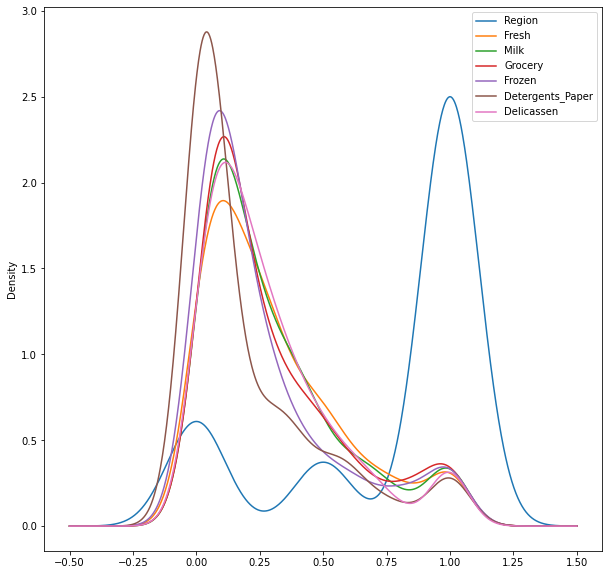

In [28]:
minmax_df.plot(kind='kde',figsize = (10,10))

<AxesSubplot:ylabel='Frequency'>

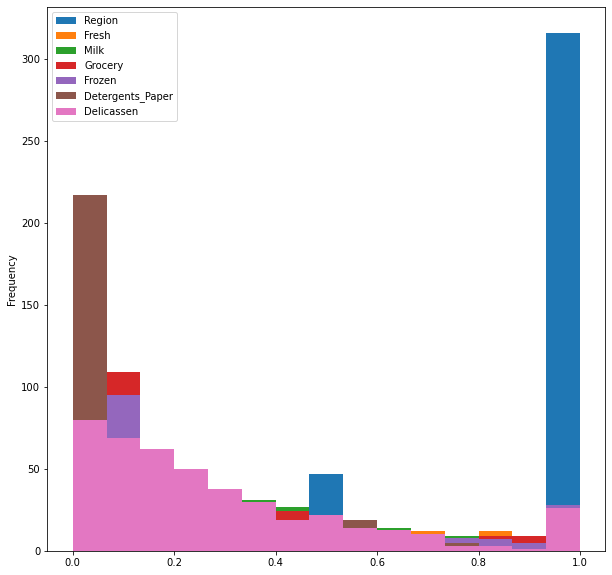

In [29]:
minmax_df.plot(kind='hist', bins=15, figsize = (10,10))

From the kde plot, we can see that, the data are highly left skewed. The MinMaxScaler method only scaled the data without normalizing it. This can be also seen in the histogram. The extreme ends has the most value while the middle has the lowest which is just opposite to the normal distirbution. This might be because of the region feature but also might be because of outliers. We had some outliers left in our dataset.

So, looking at the kde and histogram plot, we can safely say, the StandardScaler did a better job in normalizing the data. We will be using the result form StandardScaler going forward with our analysis.

In [30]:
X = standard_df.copy()
X

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.590668,0.133570,0.997442,0.043725,-0.883185,0.038885,0.033776
1,0.590668,-0.421910,1.031279,0.344587,-0.324233,0.224489,0.409771
2,0.590668,-0.491593,0.811115,0.062164,-0.092059,0.291354,2.735616
3,0.590668,0.192563,-0.861430,-0.456961,1.351901,-0.610877,0.420072
4,0.590668,1.118034,0.064490,-0.010691,0.453172,-0.230075,2.735616
...,...,...,...,...,...,...,...
435,0.590668,1.819610,1.523682,1.312831,2.625340,-0.708327,0.777181
436,0.590668,2.523909,-0.809794,-0.975187,0.668015,-0.735013,0.899079
437,0.590668,0.317873,2.278876,2.513054,-0.802664,2.848187,0.487888
438,0.590668,-0.101905,-0.688946,-0.755125,-0.585655,-0.712524,0.709365


In [31]:
y

0      2
1      2
2      2
3      1
4      2
      ..
435    1
436    1
437    2
438    1
439    1
Name: Channel, Length: 440, dtype: int64

### Implementing XGBoost Classifier

In [47]:
y[y==2] = 0
y[y==1] = 1

As per the requirement since version 1.3.2 of XGBoostClassifer, the target column has to start from 0. As, we had 1 and 2 as our target values. So, now we are just changing the values to 0 and 1 as per the requirement.

In [48]:
y

0      0
1      0
2      0
3      1
4      0
      ..
435    1
436    1
437    0
438    1
439    1
Name: Channel, Length: 440, dtype: int64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=111)

In [50]:
xgb = XGBClassifier()

In [51]:
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5)

print("The average cross validation score for Linear Regression: ",scores_xgb.mean())
print()
print("Cross validation scores:",scores_xgb)

The average cross validation score for Linear Regression:  0.928609201480698

Cross validation scores: [0.87096774 0.9516129  0.9516129  0.93442623 0.93442623]


The xgboost classifer was able to give us a score of 0.92 which would be our baseline score. We are going to perform hyperparameter tuning to increase our score.

In [52]:
def print_results(results):

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']

    print('Score: {} \n BEST PARAMS: {}\n'.format(results.best_score_,results.best_params_))

    
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 2), round(std * 2, 2), params))

In [53]:
parameters = {
    'n_estimators': [1, 5, 10, 50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1,1],
    'gamma':[0,0.5,1],
    'reg_alpha':[0,0.5,1,5],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse', 'logloss', 'mlogloss']
}

xgb_model = GridSearchCV(xgb, parameters, cv=5)
xgb_model.fit(X_train, y_train)

print_results(xgb_model)


Score: 0.938339502908514 
 BEST PARAMS: {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.05, 'n_estimators': 200, 'reg_alpha': 0}

0.92 (+/-0.06) for {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1, 'reg_alpha': 0}
0.91 (+/-0.07) for {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1, 'reg_alpha': 0.5}
0.91 (+/-0.07) for {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1, 'reg_alpha': 1}
0.88 (+/-0.05) for {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 1, 'reg_alpha': 5}
0.92 (+/-0.05) for {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 5, 'reg_alpha': 0}
0.91 (+/-0.07) for {'booster': 'gbtree', 'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 5, 'reg_alpha': 0.5}
0.91 (+/-0.07) for {'booster': 'gb

We can see that, with the help of GridSearchCV and hyperparameter tuning, we are able to increase our model accuracy. Now, with the parameters, we will be testing the model with unseen dataset and figure out if it will be able to properly generalize the unseen data points.

In [54]:
xgb = xgb_model.best_estimator_
xgb

XGBClassifier(eval_metric='rmse', learning_rate=0.05, n_estimators=200)

In [55]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 4)
    precision = round(precision_score(labels, pred,average='weighted'), 4)
    recall = round(recall_score(labels, pred, average='weighted'), 4)
    confusion_m = confusion_matrix(labels, pred)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                          
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))
    print('\n')
    print(confusion_m)
    print('\n')
    print(classification_report(labels,pred))

In [56]:
evaluate_model('XGBoost Classifier',xgb, X_test,y_test)

XGBoost Classifier -- Accuracy: 0.9015 / Precision: 0.9013 / Recall: 0.9015 / Latency: 2.0ms


[[44  7]
 [ 6 75]]


              precision    recall  f1-score   support

           0       0.88      0.86      0.87        51
           1       0.91      0.93      0.92        81

    accuracy                           0.90       132
   macro avg       0.90      0.89      0.90       132
weighted avg       0.90      0.90      0.90       132



With the new or unseen data, our model was able to generalize those points with an accuracy of 0.9015 or 90.15%, Precision of 90.13%, Recall of 90.15% with the time of 2.0ms. Our model was not able to correctly predict about 13 data points which can be seen in the confusion matrix i.e the False Positive and False Negative. The accuracy of 90% also implies that, our model is not overfitted or underfitted.